In [1]:
import torch
import json
import os
import shutil
import random
from skimage.io import imread 
from skimage.transform import resize
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.metrics import classification_report

In [2]:
# check if GPU is available 
torch.cuda.is_available()

True

In [3]:
PROJECT_ROOT = os.getcwd()

In [4]:
train_path = PROJECT_ROOT +'/train/'
validation_path = PROJECT_ROOT +'/validation/'

In [5]:
import numpy as np
import random

In [6]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

In [7]:
from glob import glob

def load_data(train_path):
    image_list = []
    label_list = []

    label_map = {
        'no_tumor': 0,
        'tumor': 1
    }
    
    # loop through each label folder
    for label_name, label_value in label_map.items():
        folder_path = os.path.join(train_path, label_name)

        # get images in the folder
        image_paths = glob(os.path.join(folder_path, '*'))
        for image_path in image_paths:
            image_list.append(image_path)
            label_list.append(label_value)
    return image_list, label_list
    

In [8]:
image_list, label_list = load_data(train_path)


In [9]:
# extract HOG features
def extract_hog_features(train_path, img_size=(128,128)):
    features = []
    feature_length_printed = False
    for path in train_path:
        try:
            image = imread(path, as_gray=True)
            image = resize(image, img_size)
            hog_feature = hog(image, pixels_per_cell=(16,16), cells_per_block=(2,2), feature_vector=True)
            if not feature_length_printed:
                feature_length_printed = True
            features.append(hog_feature)   
               
        except Exception as e:
            print(f"Fail to process {path}: {e}")
    
    return np.array(features)

In [11]:
import os
import random
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
from sklearn.svm import SVC
from joblib import dump
import time
from tqdm import tqdm

save_dir_svm_extension = os.path.join(PROJECT_ROOT, 'base_SVM_HOG_new_extension')
os.makedirs(save_dir_svm_extension, exist_ok = True)

num_runs = 3
accuracies = []
best_acc = 0.0
best_model = None
start_time = time.time()

for run in range(num_runs):
    print(f"\n===== Run {run + 1} =====")
    random.seed(42 + run)
    # load training data
    X_train_paths, y_train = load_data(train_path)
    combined_train = list(zip(X_train_paths, y_train))
    random.shuffle(combined_train)
    X_train_paths, y_train = zip(*combined_train)

    X_val_paths, y_val = load_data(validation_path)
    combined_val = list(zip(X_val_paths, y_val))
    random.shuffle(combined_val)
    X_val_paths, y_val = zip(*combined_val)

    # extract HOG features
    X_train = extract_hog_features(X_train_paths)
    X_val = extract_hog_features(X_val_paths)

    # train SVM classifier
    clf = SVC(kernel='linear', probability=True)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    print(classification_report(y_val, y_pred))
    accuracies.append(acc)

    print(f"Accuracy for run {run + 1}: {acc:.4f}")

    # track the best model
    if acc > best_acc:
        best_acc = acc
        best_model = clf
        print('save best SVM + HOG model')

# save the best model
model_save_path_extension = os.path.join(save_dir_svm_extension, 'best_svm_hog_model_extension.pkl')
dump(best_model, model_save_path_extension)
# Print relative path only
print("\nBest model saved to:", os.path.relpath(model_save_path_extension))


print(f'\nDuration: {time.time() - start_time:.0f} seconds') # Print time elapsed

# final result
print("\n=== Final Averaged Result ===")
print(f"Validation Accuracy: {np.mean(accuracies):.4f} +- {np.std(accuracies):.4f}")



===== Run 1 =====
              precision    recall  f1-score   support

           0       0.85      0.86      0.86        59
           1       0.98      0.98      0.98       371

    accuracy                           0.96       430
   macro avg       0.91      0.92      0.92       430
weighted avg       0.96      0.96      0.96       430

Accuracy for run 1: 0.9605
save best SVM + HOG model

===== Run 2 =====
              precision    recall  f1-score   support

           0       0.85      0.86      0.86        59
           1       0.98      0.98      0.98       371

    accuracy                           0.96       430
   macro avg       0.91      0.92      0.92       430
weighted avg       0.96      0.96      0.96       430

Accuracy for run 2: 0.9605

===== Run 3 =====
              precision    recall  f1-score   support

           0       0.85      0.86      0.86        59
           1       0.98      0.98      0.98       371

    accuracy                           0.96  

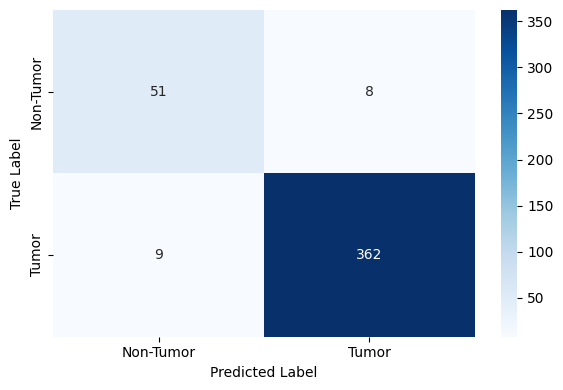

In [12]:
# confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Tumor', 'Tumor'],
            yticklabels=['Non-Tumor','Tumor'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('')
plt.tight_layout()
plt.show()

In [13]:
no_tumor_train_image = []
for i, label in enumerate(y_train):
    if label == 0:
        non_tumor_image_train_path = X_train_paths[i]
        no_tumor_train_image.append(non_tumor_image_train_path)
        

In [16]:
len(no_tumor_train_image)

276

In [19]:
tumor_train_image = []
for i, label in enumerate(y_train):
    if label == 1:
        tumor_image_train_path = X_train_paths[i]
        tumor_train_image.append(tumor_image_train_path)

In [20]:
len(tumor_train_image)

1732